In [ ]:
#...omitted data loading and preprocessing steps

## Visit Segmentation (GMM)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from scipy.stats import norm

def fit_gmm_and_find_threshold(gaps, g_compn=2, plot=False):
    # Reshape for sklearn
    X = gaps.reshape(-1, 1)

    # Fit 2-component GMM
    gmm = GaussianMixture(n_components=g_compn, random_state=0)
    gmm.fit(X)

    means = gmm.means_.flatten()
    stds = np.sqrt(gmm.covariances_).flatten()
    weights = gmm.weights_.flatten()

    # Order components by mean
    idx = np.argsort(means)
    m1, m2 = means[idx]
    s1, s2 = stds[idx]
    w1, w2 = weights[idx]

    # Find intersection point of the two Gaussians
    # Solve: w1 * N1(x) = w2 * N2(x)
    def intersection_point():
        a = 1/(2*s1**2) - 1/(2*s2**2)
        b = m2/(s2**2) - m1/(s1**2)
        c = m1**2/(2*s1**2) - m2**2/(2*s2**2) + np.log((s2 * w1) / (s1 * w2))
        roots = np.roots([a, b, c])
        return np.max(roots.real)  # higher intersection

    threshold = intersection_point()

    if plot:
        x = np.linspace(0, max(gaps) + 50, 1000)
        pdf1 = w1 * norm.pdf(x, m1, s1)
        pdf2 = w2 * norm.pdf(x, m2, s2)
        plt.hist(gaps, bins=30, density=True, alpha=0.4, label='Gap Histogram')
        plt.plot(x, pdf1, label='GMM Component 1')
        plt.plot(x, pdf2, label='GMM Component 2')
        plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.1f} days')
        plt.title('GMM Fit to Time Gaps')
        plt.xlabel('Gap between events (days)')
        plt.legend()
        plt.show()

    return threshold

def segment_visits_gmm(data_dict=pooled_data_all, proband_key='HRO_10399', g_compn=2, plot_gmm=False):
    data_patient = pd.DataFrame(
        data_dict[proband_key],
        columns=['event', 'index', 'datetime']
    )
    data = data_patient.sort_values('datetime').reset_index(drop=True)
    data['datetime'] = pd.to_datetime(data['datetime'])
    gaps = data['datetime'].diff().dt.days.dropna().values

    if len(gaps) < 2:
        # Not enough data to apply GMM
        data['visit'] = 0
        return data

    threshold = int(fit_gmm_and_find_threshold(gaps, g_compn, plot=plot_gmm))

    visit_id = 0
    visit_ids = []
    visit_start = data.loc[0, 'datetime']

    for dt in data['datetime']:
        gap = (dt - visit_start).days
        print(dt, visit_start, gap, threshold)
        if gap >= int(threshold):
            visit_id += 1
            visit_start = dt
        visit_ids.append(visit_id)

    data['visit'] = visit_ids

    # Label visits: BL, F1, F2, ...
    label_map = {v: 'BL' if i == 0 else f'F{i}' for i, v in enumerate(sorted(set(visit_ids)))}
    data['visit_label'] = data['visit'].map(label_map)

    # Time from baseline
    baseline_datetime = data.loc[data['visit_label'] == 'BL', 'datetime'].min()
    data['days_from_BL'] = (data['datetime'] - baseline_datetime).dt.days
    data['months_from_BL'] = ((data['datetime'] - baseline_datetime) / np.timedelta64(1, 'M')).round(1)

    return data

segment_visits_gmm(data_dict=pooled_data_all, proband_key='HRO_15852', plot_gmm=True)

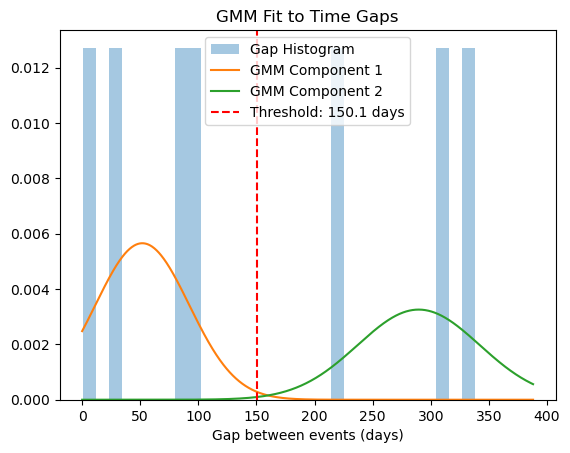

### Medical Imaging Anonymisation

In [ ]:
#---- omitted data loading logic----

In [ ]:
ct_dir = "/mnt/mrt/Describe/_downloaded/Muttray_FDG-PET/0050311816 MUTTRAY GTZ/2930177 PET FDG_Hirn/CT HeadLow Dose CT/"


# --- Manual face region selection and debugging for a CT scan from DICOM folder ---

# 1. Load the CT DICOM folder as a NIfTI image
dicom_folder = ct_dir  # <-- Change this to your DICOM folder
nimg = load_dicom(dicom_folder)
d = nimg.get_fdata()
print(f"Loaded CT image shape: {d.shape}")

# 2. Compute the offset image
modality = 'CT'
offset = face.make_offset_img(nimg, modality)
offset_shape = offset.shape
print("Offset image shape:", offset_shape)

# 3. Visualize the offset image (original, not rescaled)
plt.figure(figsize=(8, 6))
plt.imshow(offset.T, cmap='gray')
plt.title('Offset Image (original, not rescaled)')
plt.gca().invert_yaxis()
plt.axis('on')
plt.show()

# 4. Show a histogram of offset values
plt.figure(figsize=(6, 3))
plt.hist(offset.flatten(), bins=100)
plt.title("Offset Value Histogram")
plt.xlabel("Offset Value")
plt.ylabel("Count")
plt.show()

# 5. Compute and plot the gradient image (for face/skin/bone boundary visualization)
zooms = nimg.header.get_zooms()
aspect = zooms[2] / zooms[0]
pixdim = zooms[0]
offset_rescaled = ndimage.zoom(offset, (1, aspect))
gmax = pixdim * 20  # CT: use higher gmax


render_orig = face.make_grad_img(offset_rescaled, gmax)

plt.figure(figsize=(8, 6))
plt.imshow(render_orig, cmap='gray')
plt.title('Gradient Image (original, normalized)')
plt.gca().invert_yaxis()
plt.axis('on')
plt.show()

# 6. Manually define region (adjust these values as needed for CT)
l, b, w, h = 200, 1, 130, 46  # Example: adjust to cover only face/skin/bone, not brain
coords = (l, b, w, h)
print("Blurring region (l, b, w, h):", coords)

# 7. Visualize the selected region and mark l, b, w, h on the offset image
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(offset.T, cmap='gray')
rect = patches.Rectangle((l, b), w, h, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
# Mark l (left)
ax.plot([l, l], [b, b + h], color='cyan', linewidth=2)
ax.text(l, b + h + 5, 'l', color='cyan', fontsize=12)
# Mark b (bottom)
ax.plot([l, l + w], [b, b], color='yellow', linewidth=2)
ax.text(l + w + 5, b, 'b', color='yellow', fontsize=12)
# Mark w (width)
ax.annotate('', xy=(l, b + h + 10), xytext=(l + w, b + h + 10),
            arrowprops=dict(arrowstyle='<->', color='lime', lw=2))
ax.text(l + w // 2, b + h + 15, 'w', color='lime', fontsize=12, ha='center')
# Mark h (height)
ax.annotate('', xy=(l + w + 10, b), xytext=(l + w + 10, b + h),
            arrowprops=dict(arrowstyle='<->', color='magenta', lw=2))
ax.text(l + w + 15, b + h // 2, 'h', color='magenta', fontsize=12, va='center', rotation=90)
ax.set_title("Selected Region with l, b, w, h Marked")
ax.invert_yaxis()
plt.show()


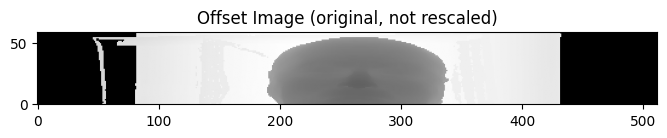
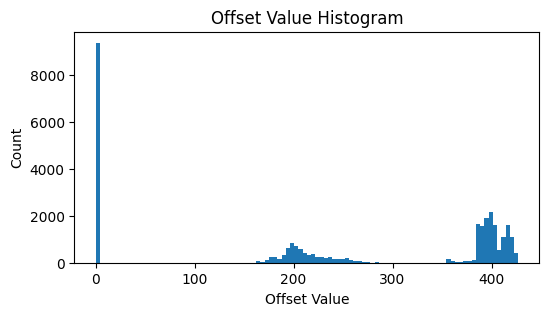

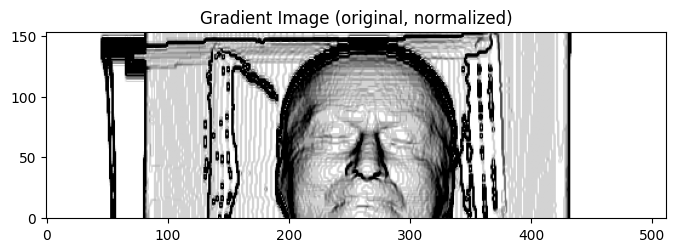

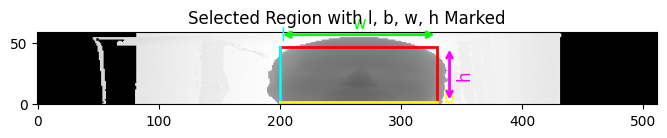

In [ ]:

# 8. Apply blur_face (skin/bone only, not brain)
anon_nimg_manual = face.blur_face(nimg, offset, coords)

# 9. Show center slices after manual anonymization
def plot_center_slices(data, title=""):
    center_x = data.shape[0] // 2
    center_y = data.shape[1] // 2
    center_z = data.shape[2] // 2
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(data[:, :, center_z], cmap='gray')
    axs[0].set_title(f"Axial (z={center_z})")
    axs[1].imshow(data[:, center_y, :], cmap='gray')
    axs[1].set_title(f"Coronal (y={center_y})")
    axs[2].imshow(data[center_x, :, :], cmap='gray')
    axs[2].set_title(f"Sagittal (x={center_x})")
    for ax in axs: ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

anon_data_manual = anon_nimg_manual.get_fdata()
plot_center_slices(anon_data_manual, title="After Manual Anonymization (CT)")

# 10. Recompute offset and gradient images for the anonymized image
offset = face.make_offset_img(anon_nimg_manual, modality)
offset_rescaled = ndimage.zoom(offset, (1, aspect))

render = face.make_grad_img(offset_rescaled, gmax)

# 11. Display the offset image (rescaled for visualization)
plt.figure(figsize=(6, 5))
plt.imshow(offset_rescaled.T, cmap='gray')
plt.title('Offset Image (rescaled, after anonymization)')
plt.gca().invert_yaxis()
plt.axis('off')
plt.show()

# 12. Display the gradient image (after anonymization)
plt.figure(figsize=(6, 5))
plt.imshow(render, cmap='gray')
plt.title('Gradient Image (after anonymization)')
plt.gca().invert_yaxis()
plt.axis('off')
plt.show()

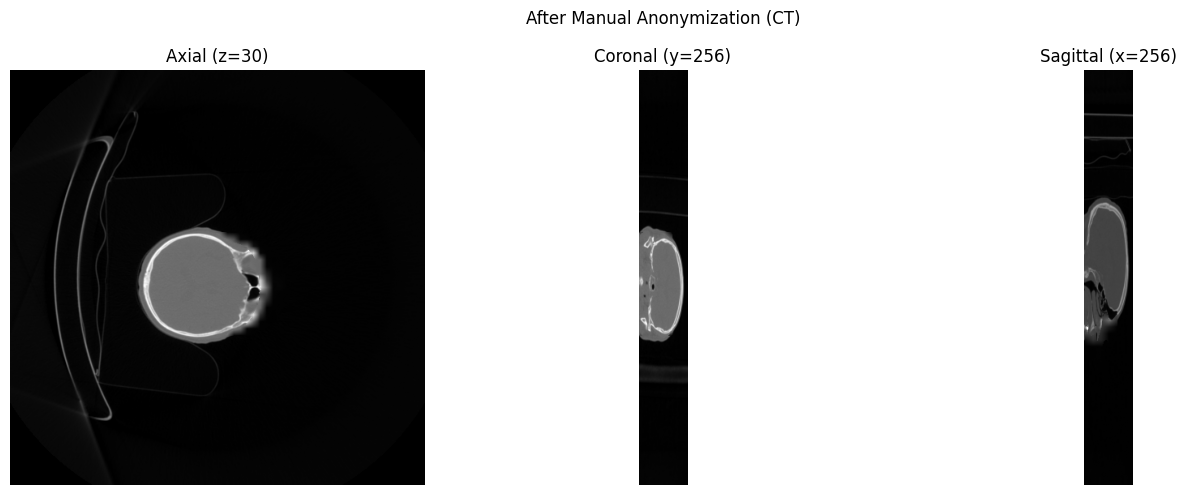

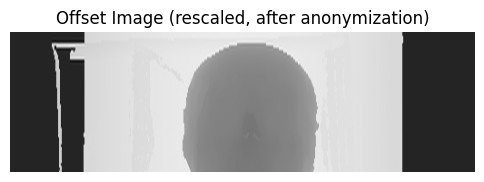

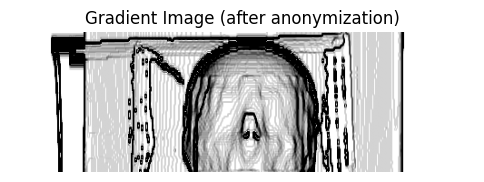